<img src="virgo_logo.png" alt="Title" style="width:300px;"/>


# Virgo Gravitational Wave Data Exercise

The aim of this exercise is to prepare a ML tool which is able to compress and clean as much as possible a dataset.

**The autoencoder coded in this exercise is only used as an opportunity to acquire some insight into ML** 

In this exercise you will:

- train a network in order to perform the job, and test their abilities



## Gravitational Wave Data

For an introduction on what GW and interferometers are please refer to https://confluence.infn.it/display/MLINFN/7.+Virgo+Autoencoder+tutorial.

For a brief vocabulary see https://labcit.ligo.caltech.edu/~ll_news/0607a_news/LIGO_Vocabulary.htm.

<div class="alert alert-info">
    <b>IGWN</b> stands for International Gravitational-Wave Observatory Network, it is a comunity made by three collaborations: LIGO VIRGO and KAGRA.<br />
    <b>Strain</b> is the effect that produces an incoming gravitational wave on our detectors, which, in the case of interferometric detectors, consists of a differential variation of the arm length. This is also the observable quantity measured by the detectors.<br />
    <b>GWF</b> stands for Gravitational Wave File and is the format IGWN used to store (not only!) interferometer strain.
</div>

All data we will use in this tutorial is freely accessibile and published by **GWOSC** (https://www.gw-openscience.org/about/). GWOSC, The Gravitational Wave Open Science Center, provides data from gravitational-wave observatories, along with tutorials and software tools. You could find there many information if you are interested.

## Data Access

To ease the reading and decoding of the data file we had already download all data on `/data/input_data/AI_INFN/gwdata/` using a python package named `gwosc`.

Gwosc aims at providing a unified and easy to use interface to access Gravitational Wave (GW) data and output some well organised datasets, ready to be used for Machine Learning projects or Data Analysis purposes (source properties, noise studies, etc.)

It this exercise we will try to encode and decode our data with an **autoencoder**

> [from wiki]: An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learned, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name

some examples of autoencoders in keras can be found at https://blog.keras.io/building-autoencoders-in-keras.html

The idea is to encoding and decoding to original dimension searching for an optimum set of parameters that makes filtered signal more similar to original one. The encoded signal will retain all needed information but with a reduction of size

We will use keras ( https://keras.io/ )
"Keras is an API designed for human beings, not machines. Keras follows best practices for reducing cognitive load: it offers consistent & simple APIs, it minimizes the number of user actions required for common use cases, and it provides clear & actionable error messages. It also has extensive documentation and developer guides."

Some usefull info:

- https://blog.keras.io/building-autoencoders-in-keras.html

- https://keras.io/api/models/


Some layers used in keras:

- **Dense** layer makes output=activation(dot(input, kernel) + bias) where kernel is the matrix of parameters and activation is the activation function. Each node is fed by the whole input!

- **Conv1D** layer applies a one-dimensional convolution to sequence data to extract local features along the temporal or spatial dimension. 

- **Dropout** layer randomly sets input units to 0 with a frequency of rate at each step during training time. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged

*Please remember, before process data with machine learning tecniques it is really important to normalize and resample at a fixed rate all the data. That's why we explained in the introduction how to do it*

## Simple autoencoder example

In [ ]:
!pip install tensorflow

In [196]:
from tensorflow import keras
from keras import layers
import numpy as np

In [197]:
# This is the size of our encoded representations
original_dim = 128
encoding_dim = 32  # 32 floats -> compression of factor 4.0, assuming the input is 128 floats

# This is our input image
input_signal = keras.Input(shape=(original_dim,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='sigmoid')(input_signal)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(original_dim, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_signal, decoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_221"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_131 (InputLayer)    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_319 (Dense)               │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_320 (Dense)               │ (None, 128)            │         4,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,352 (32.62 KB)

 Trainable params: 8,352 (32.62 KB)

 Non-trainable params: 0 (0.00 B)

The code in the previous cell defines an autoencoder model that reduces the sample size from 128 elements to 32 (encoding) and then reconstructs it back from 32 to 128 (decoding). To train the model, you need to define a training and a test dataset, and execute the `fit` instruction.
```
autoencoder.fit(
    x_train, x_train,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)
```
To apply inference on real data, (i.e. encode and decode data) you can execute the `predict` instruction:

```
decoded_data = autoencoder.predict(original_data)
```

Let's create a random input signal() mean=0 std=3) of 128*1000 elements to test the model

```
original_dim
noise = np.random.normal(0, 3, original_dim*1000)
X_signal = noise.reshape((1000, original_dim))
x_train = X_signal[900:]
```
Try to train the model on this data and then apply inference.

## Exercise 1 Simple autoencoder whith convolution layer on random sample

Use the previous model, adding one convolution layer. The workflow will be the following:
```
original -> convolution -> encoded size 32 ->  encoded size 16 -> decoded size 32 -> decoded size original
```
It is convenient to play a bit with layers that expect a different number of dimension in this case

Conv1D expects a 3d signal, for this reason we will add a singleton dimension doing

```
shape=(original_dim,1)
```

please note the "1" added to the list of the dimension

Example:

```
input_signal = keras.Input(shape=(original_dim,1))
convolved = layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation='sigmoid')(input_signal)
```


### Create input data

Create a random signal of 1000 samples (1D vectors) with 128 elements each using NumPy (np.random). Then split the created dataset into x_train (900 samples) and x_test (100 samples).

PLot the data with matplotlib:

In [ ]:
!pip install matplotlib

In [218]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends

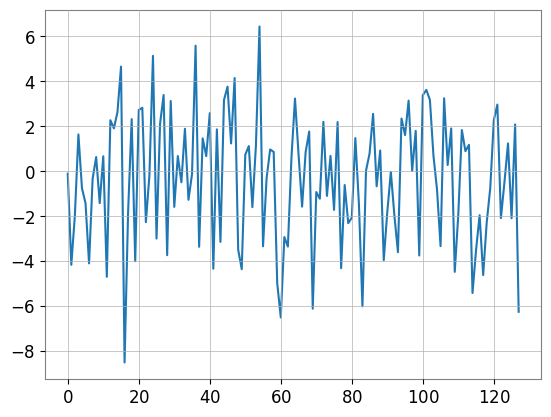

In [219]:
plt.plot(X_signal[0,:,0], label='Sample')

### Create the model

Then create the model with the following dimension:
```
original_dim = 128
encoding_dim = 32  # 32 floats -> compression of factor 4.0, assuming the input is 128 floats
encoding_dim_1 = 16  # 16 floats -> compression of factor 8.0, assuming the input is 128 floats
```

Now use the model as encoder or decoder to split the model in two and execute the `predict` instruction on each part.
Plot the decoded data: why is so different from original?

## Excercise 2: Encoder and decoder on MNIST database

In this exercise, you are asked to download the MNIST dataset (28x28 pixel 2D images of handwritten digits, each pixel with a value from 0 to 255) and train an autoencoder on it:
```
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
```

Build an autoencoder that takes 28x28 matrices as input and performs a Flatten operation. Then, add two Dense layers that reduce the dimension first to 128 units, and then to 32 units.

The decoding process should be done through two Dense layers that bring the sample back to its original size (after Flattening), and finally, add a Reshape layer to bring the sample back to 28x28 elements.

#### Activation Functions

- **Encoding**: `ReLU -> ReLU`
- **Decoding**: `ReLU -> Sigmoid`

**Note**: Since the sigmoid output ranges between 0 and 1, **the pixel intensity values must be normalized accordingly**.

#### Training

Train the network for 10 epochs, using the training data and validation data from the images downloaded in `(x_train, _), (x_test, _)`.

#### Inference and Plotting

Perform inference on a test sample and plot the result.




In [24]:
## Excercise 2: Encoder and decoder on MNIST database

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

## Exercise 3: Autoencoder on real gravitational data with and without convolution layers

The final exercise consists of creating two autoencoders—one with convolutional layers and one without—to compress and decompress data from a gravitational wave detector of the IGWN collaboration (Virgo and LIGO). To access and download a Gravitational Wave sample, you will have to use `gwosc`library. If importing gwpy gives an error, then perform a downgrade of numpy<2.0.

```
!pip install gwosc

from gwosc.datasets import event_gps
from gwosc import datasets
from gwpy.timeseries import TimeSeries

import h5py
gws=datasets.find_datasets(detector="L1")
gws_filtered = [s for s in gws if s.startswith(("GW1", "GW2"))]
for el in gws_filtered:
    print(el)
    gps = event_gps(el)
    start = int(gps) - 16   # seconds before
    end = int(gps) + 16     # seconds aftes
    data = TimeSeries.fetch_open_data('L1', start, end)
    with h5py.File( save_dir+el+'.h5', 'w') as f:
        f.create_dataset('data', data=data)
```

For this exercise **the data have already been downloaded** to the directory `/data/input_data/AI_INFN/gwdata` in Timeseries format and can be loaded into memory using the gwpy library:
```
all_files = [f for f in os.listdir(data_dir) if f.endswith(".hdf5")]
files_to_load = all_files[:NFILES]
time_series_list = []
counter=0
for fname in files_to_load:
    counter=counter+1
    path = os.path.join(data_dir, fname)
    #print(f"Carico {path} ...")
    ts = TimeSeries.read(path)
    array = np.array(ts)
    splitted = np.split(array, NSAMPLES)
    time_series_list.extend(splitted)
chunks = np.stack(time_series_list)
chunks = chunks[..., np.newaxis]  # shape: (dim_split, NSAMPLES, 1)
```
with:
- NFILES: number of files to load (100 will be enough)
- NSAMPLES: number of chunks into which each file must be divided (start with 32).

Each file represents a 32-second sequence sampled at 4096 Hz, hence each chunk will contain 4096 elements (1 second). We will create NSAMPLES chunks of (4096 * 32 / NSAMPLES) elements. 


In [ ]:
!pip install gwpy

In [31]:
import numpy as np
import os
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, TimeDistributed, Flatten, Reshape, Input, Conv1D, Conv1DTranspose, Activation, InputLayer
from keras import optimizers
from keras.optimizers import Nadam, Adam, SGD
from keras import regularizers
import tensorflow as tf
from gwpy.timeseries import TimeSeries

In [32]:

data_dir="/data/input_data/AI_INFN/gwdata"

NSAMPLES=32
NFILES=100
FREQ=4096
SECS=32

total_points_single = SECS*FREQ
total_points = NFILES*total_points_single
WINDOWSIZE = int(total_points_single / NSAMPLES)
dim_split = total_points / WINDOWSIZE
print (f'Number of input points: {WINDOWSIZE}')

Number of input points: 4096


In [33]:
## READING FILES



For the autoencoders you will develop, you will use the hyperbolic tangent activation function, which has a range between -1 and 1. Therefore, you need to normalize your data values accordingly:
```
X_min = chunks.min(axis=1, keepdims=True)
X_max = chunks.max(axis=1, keepdims=True)
chunks_norm = 2 * (chunks - X_min) / (X_max - X_min) - 1
```

### Autoencoder model without convolution layers

Now build an autoencoder with 4 Dense layers — two for encoding and two for decoding. Split each file in 32 chunks, each of 1 second (4096 elements)
```
original (size 4096) -> flatten -> encoded size 512 ->  encoded size 16 -> decoded size 32 -> decoded size original
```
Split the network so that you can extract and plot the encoded result. The encoding output dimension should be 64. Note that you have to first flatten the input chunks, as we have no convolution layer in your model:
```
encoder.add(Flatten(input_shape=(input_dim, 1)))
```
---

#### Input

- `Input(shape=(input_dim, 1))`  
  The input signal is a 1D vector of length `input_dim`.  
  It is first **flattened** to prepare it for the fully connected layers.

---

#### Encoder

- **Flatten**  
  Converts the 1D input of shape `(input_dim, 1)` into a flat vector of size `input_dim`.

- **Dense(_num_neuroni, activation='tanh')**  
  The first encoding layer learns a non-linear transformation of the input.  
  Regularization (`l1_l2`) can be applied to both kernel and bias terms through the parameters `bias1`, `bias2`, `ker1`, and `ker2`.

- **Dense(_latent_dim, activation='tanh')**  
  This is the **latent (bottleneck) layer**, where the model compresses the information into a lower-dimensional representation of size `_latent_dim`.

---

#### Decoder

- **Dense(_num_neuroni, activation='tanh')**  
  The decoder begins reconstructing the signal from the latent representation.

- **Dense(input_dim, activation='tanh')**  
  Reconstructs the signal back to its original dimension.

- **Reshape((input_dim, 1))**  
  Reshapes the output to match the input format.

---

#### Model Compilation

- **Loss:** `mse` (Mean Squared Error)  
  Measures how close the reconstructed output is to the input.

- **Optimizer:** `Adam(learning_rate=1e-4)`  
  Adaptive learning rate optimizer for stable convergence.

- **Metrics:** `mse`  
  Tracks the reconstruction error during training.

---

### Autoencoder model with convolution layers

Finally  build an autoencoder with 3 Conv1D layers and one Dense  for encoding. Split the network so that you can extract and plot the encoding result.
As before, the input data dimension is 4096 

---

####  Input

- `Input(shape=(input_dim, 1))`  
  The input signal is a 1D vector (e.g., a signal or time series) of length `input_dim`.

---

####  Encoder

- **Conv1D (3 layers)**  
  Applies convolutional filters to extract local features from the signal, progressively reducing its dimensionality via `strides=2`.  
  Uses the `tanh` activation function to introduce non-linearity.

- **Flatten**  
  Converts the 3D tensor into a 1D vector.

- **Dense(_latent_dim)**  
  Compresses the information into a **latent code** of size `_latent_dim`.  
  This is the compact representation of the input signal.

---

####  Decoder

- **Dense(input_dim // 8 * 64)**  
  Expands the latent code to match the encoder’s output shape.

- **Reshape((input_dim // 8, 64))**  
  Reshapes the vector into a 3D tensor suitable for transposed convolutions.

- **Conv1DTranspose (3 layers)**  
  Performs the inverse of convolution — progressively upsampling the signal.  
  The first two layers reconstruct intermediate features, and the last one generates the final output.

- **Activation('tanh')**  
  Ensures that the reconstructed signal lies within the same range as the input.

---

####  Model Compilation

- **Loss:** `mse` (Mean Squared Error)  
  Measures the difference between input and reconstructed output.

- **Optimizer:** `adam`  
  Adaptive optimizer ensuring efficient convergence.



### Training and plotting results

Train your models splitting the data in 90% training and 10% validation using `validation_split=0.1`  and plot "the training vs validation loss" graph